## Compare photometry in the new  Stripe82 catalog 
## to Gaia DR2 photometry and derive corrections for 
## gray systematics using Gmag photometry

#### input: N2020_stripe82calibStars.dat
#### output: stripe82calibStars_v4.1.dat 
#### files with RA/Dec corrections: ZPcorrectionsRA_v4.1_final.dat and ZPcorrectionsDec_v4.1_final.dat
### makes paper plots:  
### GmagCorrection_RA_Hess.png  GmagCorrection_Dec_Hess.png	
### GmagCorrectionTest_Gmag_Hess.png

In [3]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.plotting import hist
# for astroML installation see https://www.astroml.org/user_guide/installation.html

In [4]:
## automatically reload any modules read below that might have changed (e.g. plots)
%load_ext autoreload
%autoreload 2
# importing ZI and KT tools: 
import ZItools as zit
import KTtools as ktt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='dataReading'></a>

### Define paths and catalogs 

In [5]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/SDSS_SSC/Data"

# the original SDSS catalog from 2007
sdssOldCat = ZIdataDir + "/" + "stripe82calibStars_v2.6.dat"
# INPUT: Karun's new catalog from 2020
sdssNewCatIn = ZIdataDir + "/" + "N2020_stripe82calibStars.dat"
readFormat = 'csv'
# OUTPUT: with Gmag-based gray corrections 
sdssNewCatOut = ZIdataDir + "/" + "stripe82calibStars_v4.1.dat" 
# Gaia EDR3 with BP and RP data
GaiaEDR3CatBR = ZIdataDir + "/" + "Stripe82_GaiaEDR3_BPRP.dat" 

In [6]:
# both new and old files use identical data structure
colnamesSDSS = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

In [7]:
%%time
# old
sdssOld = Table.read(sdssOldCat, format='ascii', names=colnamesSDSS) 
np.size(sdssOld)

CPU times: user 22 s, sys: 3.75 s, total: 25.7 s
Wall time: 24.9 s


1006849

In [10]:
%%time
# new 
sdssNew = Table.read(sdssNewCatIn, format=readFormat, names=colnamesSDSS)
np.size(sdssNew)

CPU times: user 4.56 s, sys: 889 ms, total: 5.45 s
Wall time: 4.64 s


1001335

#### Simple positional match using ra/dec

In [11]:
sdssOld_coords = SkyCoord(ra = sdssOld['ra']*u.degree, dec= sdssOld['dec']*u.degree) 
sdssNew_coords = SkyCoord(ra = sdssNew['ra']*u.degree, dec= sdssNew['dec']*u.degree) 
# this is matching sdssNew to sdssOld, so that indices are into sdssNew catalog
# makes sense in this case since the sdssOld catalog is (a little bit) bigger 
# than sdssNew (1006849 vs 1005470)
idx, d2d, d3d = sdssNew_coords.match_to_catalog_sky(sdssOld_coords)  

In [12]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
new_old = hstack([sdssNew, sdssOld[idx]], table_names = ['new', 'old'])
new_old['sep_2d_arcsec'] = d2d.arcsec
# good matches between the old and new catalogs
MAX_DISTANCE_ARCSEC = 0.5
sdss = new_old[(new_old['sep_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
print(np.size(sdss))

1000140


### apply standard cuts as in old catalog:


In [13]:
mOK3 = sdss[sdss['ra_new']<1]
mOK3 = zit.selectCatalog(sdss, mOK3)

starting with 1000140
after Nobs cuts: 996147
after chi2 cuts: 993774
after r_mErr cut: 991472


In [14]:
print(996147/1006849)
print(993774/1006849)
print(991472/1006849)

0.989370799394944
0.9870139415145668
0.9847276006630588


### now match to Gaia EDR3...

In [30]:
colnamesGaia = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra', 'pmdec']
colnamesGaia = colnamesGaia + ['BPmag', 'BPeI', 'RPmag', 'RPeI', 'BRef']
gaia = Table.read(GaiaEDR3CatBR, format='ascii', names=colnamesGaia)
gaia['raG'] = gaia['ra']
gaia['decG'] = gaia['dec']    
gaia['GmagErr'] = gaia['fluxErr'] / gaia['flux'] 
gaia['BR'] = gaia['BPmag'] - gaia['RPmag'] 
gaia['GBP'] = gaia['Gmag'] - gaia['BPmag']
gaia['GRP'] = gaia['Gmag'] - gaia['RPmag']

In [31]:
sdss_coords = SkyCoord(ra = sdss['ra_old']*u.degree, dec= sdss['dec_old']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['raG']*u.degree, dec= gaia['decG']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idxG, d2dG, d3dG = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaia, sdss[idxG]], table_names = ['gaia', 'sdss'])
gaia_sdss['sepSG_2d_arcsec'] = d2dG.arcsec

In [32]:
### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def derivedColumns(matches):
    matches['dra'] = (matches['ra_new']-matches['ra_old'])*3600
    matches['ddec'] = (matches['dec_new']-matches['dec_old'])*3600
    matches['ra'] = matches['ra_old']
    ra = matches['ra'] 
    matches['raW'] = np.where(ra > 180, ra-360, ra) 
    matches['dec'] = matches['dec_old']
    matches['u'] = matches['u_mMed_old']
    matches['g'] = matches['g_mMed_old']
    matches['r'] = matches['r_mMed_old']
    matches['i'] = matches['i_mMed_old']
    matches['z'] = matches['z_mMed_old']
    matches['ug'] = matches['u_mMed_old'] - matches['g_mMed_old']
    matches['gr'] = matches['g_mMed_old'] - matches['r_mMed_old']
    matches['ri'] = matches['r_mMed_old'] - matches['i_mMed_old']
    matches['gi'] = matches['g_mMed_old'] - matches['i_mMed_old']
    matches['du'] = matches['u_mMed_old'] - matches['u_mMed_new']
    matches['dg'] = matches['g_mMed_old'] - matches['g_mMed_new']
    matches['dr'] = matches['r_mMed_old'] - matches['r_mMed_new']
    matches['di'] = matches['i_mMed_old'] - matches['i_mMed_new']
    matches['dz'] = matches['z_mMed_old'] - matches['z_mMed_new']
    # Gaia 
    matches['draGold'] = -3600*(matches['ra_old'] - matches['raG']) 
    matches['draGnew'] = -3600*(matches['ra_new'] - matches['raG']) 
    matches['ddecGold'] = -3600*(matches['dec_old'] - matches['decG']) 
    matches['ddecGnew'] = -3600*(matches['dec_new'] - matches['decG']) 
    # photometric
    matches['gGr_old'] = matches['Gmag'] - matches['r_mMed_old']
    matches['gGr_new'] = matches['Gmag'] - matches['r_mMed_new']
    matches['gRPr_new'] = matches['RPmag'] - matches['r_mMed_new']
    return

In [33]:
derivedColumns(gaia_sdss) 

### Select good matches and compare both catalogs to Gaia DR2

In [34]:
# doGaiaAll(mOK)
def doGaiaGmagCorrection(d, Cstr, Gmax=20.0, yMax=0.03):
    # Cstr = 'gGr_old' or 'gGr_new'  
    gi = d['gi']
    Gr = d[Cstr]
    Gmag = d['Gmag']
    zit.qpBM(d, 'gi', -1, 4.5, Cstr, -2, 1.0, 56) 

    xBin, nPts, medianBin, sigGbin = zit.fitMedians(gi, Gr, -0.7, 4.0, 47, 0)  
    data = np.array([xBin, medianBin, sigGbin])
    Ndata = xBin.size
    ### HERE WE ARE FITTING 7-th ORDER POLYNOMIAL TO Gmag-rSDSS vs. g-i ###
    # get best-fit parameters  
    thetaCloc = zit.best_theta(data,7)
    # generate best fit lines on a fine grid 
    xfit = np.linspace(-1.1, 4.3, 1000)
    yfit = zit.polynomial_fit(thetaCloc, xfit) 
    ## added "Poly" because switched to piecewise linear interpolation below
    d['gGrFitPoly'] = zit.polynomial_fit(thetaCloc, gi)
    d['dgGrPoly'] = d[Cstr] - d['gGrFitPoly']  
    ### PIECEWISE LINEAR INTERPOLATION (AS FOR ALL OTHER COLORS AND SURVEYS)
    d['gGrFit'] = np.interp(gi, xBin, medianBin)
    d['dgGr'] = d[Cstr] - d['gGrFit']   
    
    # SELECT FOR RECALIBRATION wrt RA and Dec
    giMin = 0.4
    giMax = 3.0 
    Dc = d[(d['gi']>giMin)&(d['gi']<giMax)]
    print('N before and after color cut:', np.size(d), np.size(Dc))
    DcB = Dc[(Dc['Gmag']>14.5)&(Dc['Gmag']<Gmax)]
    DcB['GrResid'] = DcB['dgGr'] - np.median(DcB['dgGr'])
    zit.printStats(DcB['dgGr'])
    DcBok = DcB[np.abs(DcB['dgGr'])<0.1]
    print(np.size(DcB), np.size(DcBok))

    zit.qpBM(DcBok, 'Gmag', 14.5, Gmax, 'GrResid', -1*yMax, yMax, 56) 
    zit.qpBM(DcBok, 'dec', -1.3, 1.3, 'GrResid', -1*yMax, yMax, 126) 
    zit.qpBM(DcBok, 'raW', -51.5, 60, 'GrResid', -1*yMax, yMax, 112) 
    
    return thetaCloc, DcBok 

In [35]:
## first limit astrometric distance and 
## require at least 4 epochs as in the old catalog
MAX_DISTANCE_ARCSEC = 0.5
m1 = gaia_sdss[(gaia_sdss['sepSG_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
a1 = m1['g_Nobs_new']
a2 = m1['r_Nobs_new']
a3 = m1['i_Nobs_new']
mOK = m1[(a1>3)&(a2>3)&(a3>3)]
print(len(new_old))
print(len(m1))
print(len(mOK))

1001335
913407
909693


In [36]:
def plotAstro2Ddiagrams(d):
    ### plots 
    plotNameRoot = 'astroVSpm_RA_pm'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'pmra', "Xmin":-40, "Xmax":40, "Xlabel":'R.A. proper motion (mas/yr)', \
          "Ystr":'draGnew', "Ymin":-0.5, "Ymax":0.5, "Ylabel":'raw SDSS R.A. - Gaia R.A. (arcsec)', \
          "XminBin":-35, "XmaxBin":35, "nBin":70, \
          "plotName":plotName, "Nsigma":0, "offset":-0.1, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

    # need to fit draGnew vs. pmra and correct for the mean trend, then plot vs. r mag
    pmra = d['pmra']
    draGnew = d['draGnew']
    xBin, nPts, medianBin, sigGbin = zit.fitMedians(pmra, draGnew, -60, 60, 120, 0)  
    ### PIECEWISE LINEAR INTERPOLATION 
    d['draGnewFit'] = np.interp(d['pmra'], xBin, medianBin)
    draCorr = d['draGnew'] - d['draGnewFit'] 
    draCorrOK = np.where(np.abs(draCorr) < 0.25, draCorr, 0)
    d['draGnewCorr'] = draCorrOK   

    plotNameRoot = 'astroVSpm_RA_r'
    plotName = plotNameRoot + '.png'  
    kw = {"Xstr":'r_mMed_new', "Xmin":14, "Xmax":21, "Xlabel":'SDSS r magnitude', \
          "Ystr":'draGnewCorr', "Ymin":-0.12, "Ymax":0.12, "Ylabel":'corr. SDSS R.A. - Gaia R.A. (arcsec)', \
          "XminBin":14, "XmaxBin":21, "nBin":30, \
          "plotName":plotName, "Nsigma":0, "offset":0.050, "symbSize":0.05}
    kw["nBinX"] = 30
    kw["nBinY"] = 24
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)


    plotNameRoot = 'astroVSpm_Dec_pm'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'pmdec', "Xmin":-40, "Xmax":40, "Xlabel":'Dec. proper motion (mas/yr)', \
          "Ystr":'ddecGnew', "Ymin":-0.5, "Ymax":0.5, "Ylabel":'raw SDSS Dec. - Gaia Dec. (arcsec)', \
          "XminBin":-35, "XmaxBin":35, "nBin":70, \
          "plotName":plotName, "Nsigma":0, "offset":-0.1, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

medianAll: 0.011876760055429259 std.dev.All: 0.08452394438024698
N= 909693 min= -0.7530682099286423 max= 0.857299626591157
median: -0.0007063674445362267 std.dev: 0.2582684458627323
saved plot as: astroVSpm_RA_pm.png


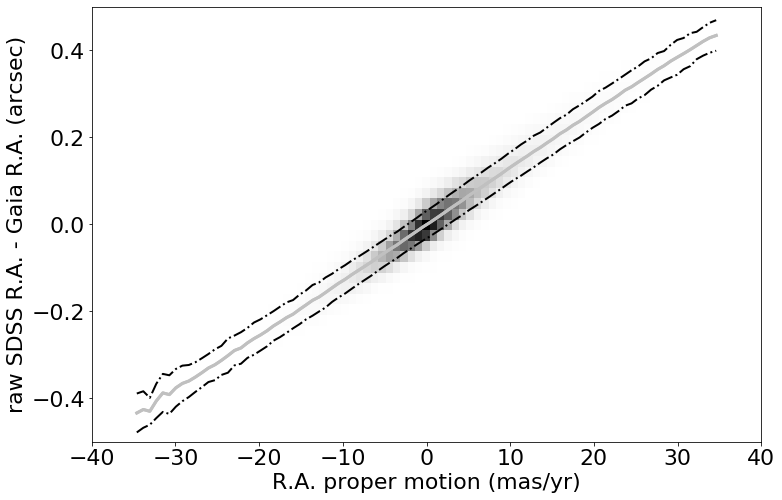

made plot astroVSpm_RA_pm.png
medianAll: 0.0 std.dev.All: 0.028114037445634333
N= 909693 min= -0.24808298477197083 max= 0.24823733963545036
median: 0.0005993032494132113 std.dev: 0.0016337585317856129
saved plot as: astroVSpm_RA_r.png


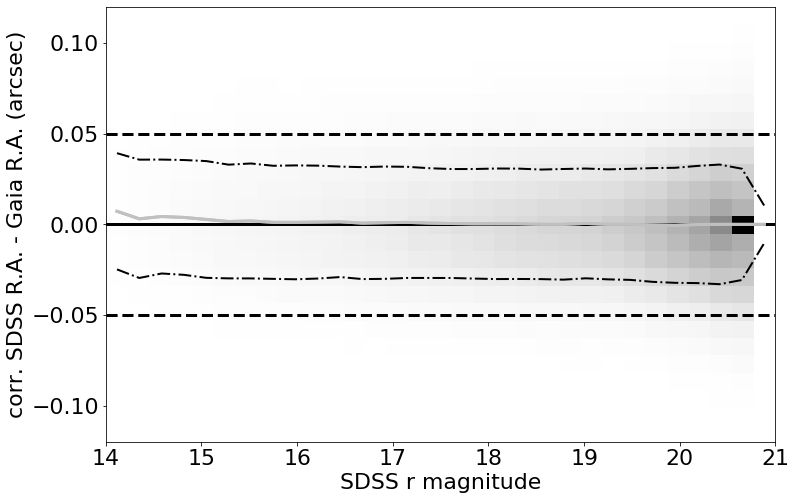

made plot astroVSpm_RA_r.png
medianAll: -0.06761045250938125 std.dev.All: 0.0696989226587182
N= 909693 min= -0.6355469751649245 max= 0.5258908825483743
median: -0.004121030564896433 std.dev: 0.26027484751713803
saved plot as: astroVSpm_Dec_pm.png


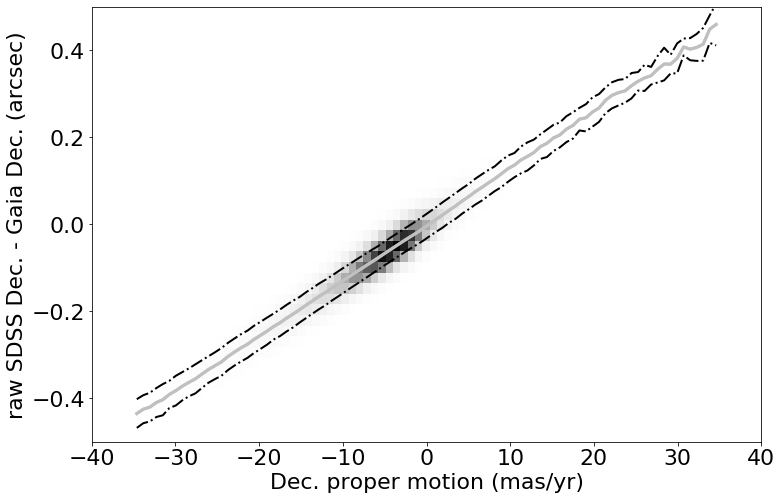

made plot astroVSpm_Dec_pm.png


In [37]:
### produce astrometric plots showing correlation with proper motions
plotAstro2Ddiagrams(mOK)
# print(np.std(mOK['draGnew']), np.std(mOK['ddecGnew'])) 
#mOK

In [38]:
x = mOK['draGnewCorr']
xOK = x[np.abs(x)<0.25]
print(np.std(xOK), zit.sigG(xOK))

0.03234104257436012 0.028114037445634333


medianAll: 0.011876760055429259 std.dev.All: 0.08452394438024698
N= 909693 min= -0.7530682099286423 max= 0.857299626591157
median: -0.0007710393219895195 std.dev: 0.3610282211211499


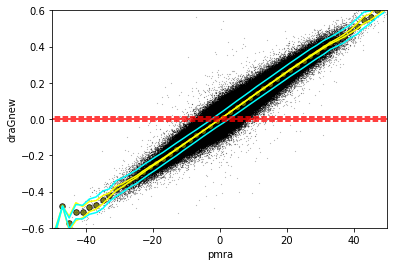

In [39]:
zit.qpBM(mOK, 'pmra', -50, 50, 'draGnew', -0.6, 0.6, 50) 

medianAll: -0.06761045250938125 std.dev.All: 0.0696989226587182
N= 909693 min= -0.6355469751649245 max= 0.5258908825483743
median: -0.04168081287304615 std.dev: 0.31886647081234365


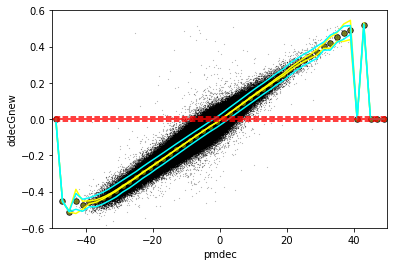

In [40]:
zit.qpBM(mOK, 'pmdec', -50, 50, 'ddecGnew', -0.6, 0.6, 50) 

medianAll: -0.011924523925781472 std.dev.All: 0.21507845659790026
N= 909693 min= -5.81342258911133 max= 10020.178951263428
median: -0.131070114135742 std.dev: 669.1624456192955


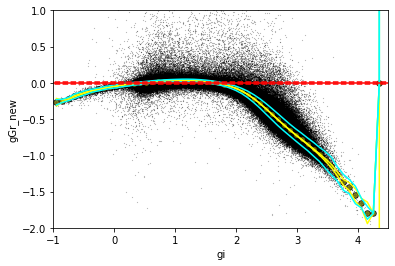

N before and after color cut: 909693 862886
            -5.667082028472902 12.567834759004116 0.0022987439270026055 10019.603316933013 547041
547041 526873
medianAll: -0.00046438235473880013 std.dev.All: 0.01802550383541689
N= 526873 min= -0.10228884318542411 max= 0.09768923178100539
median: 0.0010030349121080313 std.dev: 0.0033106027056170554


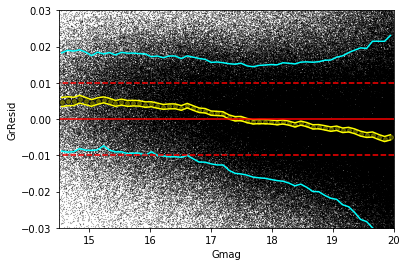

medianAll: -0.00046438235473880013 std.dev.All: 0.01802550383541689
N= 526873 min= -0.10228884318542411 max= 0.09768923178100539
median: -7.206434631361856e-05 std.dev: 0.006501498141536277


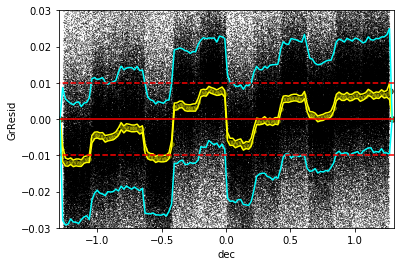

medianAll: -0.00046438235473880013 std.dev.All: 0.01802550383541689
N= 526873 min= -0.10228884318542411 max= 0.09768923178100539
median: 0.00034947959899737794 std.dev: 0.0034541270998725256


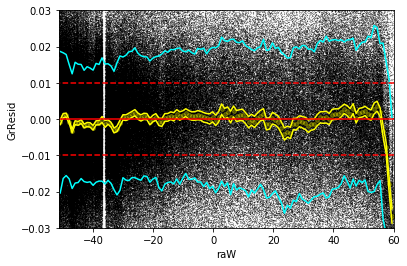

In [41]:
theta, mOKc = doGaiaGmagCorrection(mOK, 'gGr_new')
thetaLoc = theta

In [42]:
## for zero point calibration, in addition to color cut in doGaiaAll, take 16 < G < 19.5 
mOKcB = mOKc[(mOKc['Gmag']>16)&(mOKc['Gmag']<19.5)]
mOKcB['GrResid'] = mOKcB['dgGr'] - np.median(mOKcB['dgGr'])
mOKcBok = mOKcB[np.abs(mOKcB['dgGr'])<0.1]
print(np.size(mOKc), np.size(mOKcB), np.size(mOKcBok))

526873 374207 374207


In [43]:
print(np.std(mOKcBok['GrResid']), zit.sigG(mOKcBok['GrResid'])) 

0.02486974166461516 0.016848900575614084


medianAll: 0.0 std.dev.All: 0.016848900575614084
N= 374207 min= -0.10185173756408536 max= 0.09812633740234414
median: 0.0005385043182378046 std.dev: 0.006486061362604072


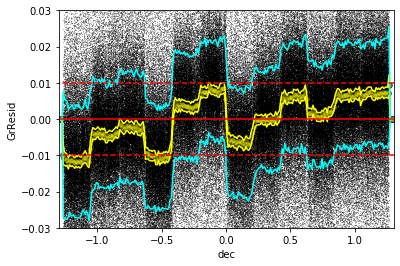

In [44]:
zit.qpBM(mOKcBok, 'dec', -1.3, 1.3, 'GrResid', -0.03, 0.03, 260) 

medianAll: 0.0 std.dev.All: 0.016848900575614084
N= 374207 min= -0.10185173756408536 max= 0.09812633740234414
median: 0.00035661710357612233 std.dev: 0.0034314293508158284


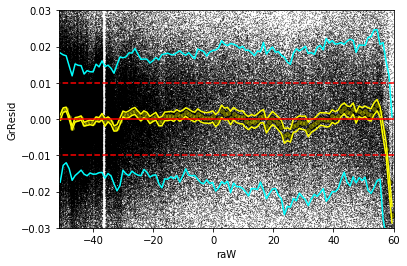

In [45]:
zit.qpBM(mOKcBok, 'raW', -51.5, 60, 'GrResid', -0.03, 0.03, 112) 

# Final Figures for the Paper 
## with Karun's 2D histogram implementation

In [46]:
def plotGmag2Ddiagrams(d):
    ### plots 
    plotNameRoot = 'GrVSgi'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'gi', "Xmin":0.0, "Xmax":3.5, "Xlabel":'SDSS g-i', \
          "Ystr":'gGr_new', "Ymin":-1.25, "Ymax":0.25, "Ylabel":'Gaia Gmag - SDSS r', \
          "XminBin":-0.5, "XmaxBin":4.0, "nBin":90, \
          "plotName":plotName, "Nsigma":3, "offset":0.0, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

def plotGmag2DdiagramsX(d, kw):
    # Gaia G
    print('-----------')
    print(' stats for SDSS r binning medians:')
    plotName = plotNameRoot + '_Gmag.png'    
    kwOC = {"Xstr":'Gmag', "Xmin":14.3, "Xmax":21.01, "Xlabel":'Gaia G (mag)', \
          "Ystr":kw['Ystr'], "Ymin":-0.06, "Ymax":0.06, "Ylabel":Ylabel, \
          "XminBin":14.5, "XmaxBin":21.0, "nBin":130, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Gmag_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 130
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)
    print('------------------------------------------------------------------')

In [47]:
def plotGmagCorrections(d, kw):
    ### REDEFINE residuals to correspond to "SDSS-others", as other cases
    d['redef'] = -1*d[kw['Ystr']] 
    kw['Ystr'] = 'redef'
    goodC = d[np.abs(d['redef'])<0.1]
    
    ### plots 
    plotNameRoot = kw['plotNameRoot']
    # RA
    print(' stats for RA binning medians:')
    plotName = plotNameRoot + '_RA.png'
    Ylabel = 'residuals for (Gmag$_{SDSS}$ - Gmag$_{GaiaDR2}$)  '
    kwOC = {"Xstr":'raW', "Xmin":-52, "Xmax":60.5, "Xlabel":'R.A. (deg)', \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":-51.5, "XmaxBin":60, "nBin":112, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_RA_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 112
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)  
    print('made plot', plotName)

    # Dec
    print('-----------')
    print(' stats for Dec binning medians:')
    plotName = plotNameRoot + '_Dec.png'
    kwOC = {"Xstr":'dec', "Xmin":-1.3, "Xmax":1.3, "Xlabel":'Declination (deg)', \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":-1.266, "XmaxBin":1.264, "nBin":252, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Dec_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 252  
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)   
    
    # Gaia G
    print('-----------')
    print(' stats for SDSS r binning medians:')
    plotName = plotNameRoot + '_Gmag.png'    
    kwOC = {"Xstr":'Gmag', "Xmin":14.3, "Xmax":21.01, "Xlabel":'Gaia G (mag)', \
          "Ystr":kw['Ystr'], "Ymin":-0.06, "Ymax":0.06, "Ylabel":Ylabel, \
          "XminBin":14.5, "XmaxBin":21.0, "nBin":130, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Gmag_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 130
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)
    print('------------------------------------------------------------------')
 

In [48]:
mOK['GrResid'] = mOK['dgGr'] - np.median(mOK['dgGr']) + 0.006
mOKok = mOK[np.abs(mOK['dgGr'])<0.1]
print(np.size(mOK), np.size(mOKok))

909693 844619


 stats for RA binning medians:
medianAll: -0.00550926013183657 std.dev.All: 0.0230543828974018
N= 841193 min= -0.09999488482666107 max= 0.09414577941894324
median: -0.006644120014190222 std.dev: 0.003183821102305531
saved plot as: GmagCorrection_RA.png


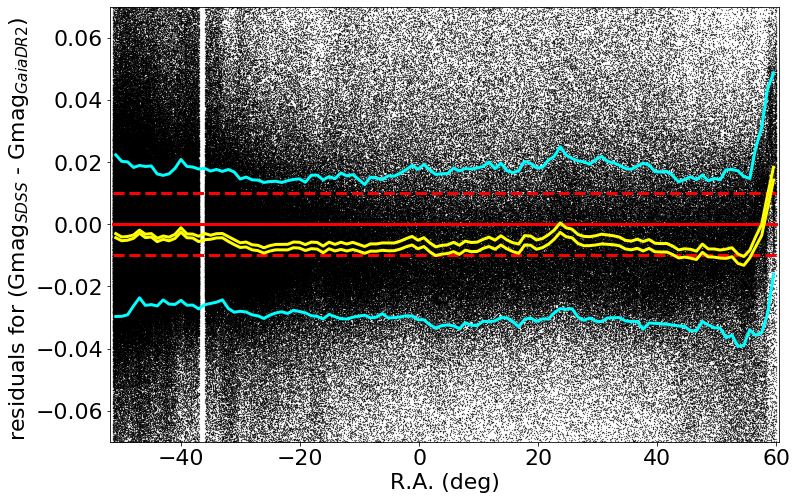

medianAll: -0.00550926013183657 std.dev.All: 0.0230543828974018
N= 841193 min= -0.09999488482666107 max= 0.09414577941894324
median: -0.006644120014190222 std.dev: 0.003183821102305531
saved plot as: GmagCorrection_RA_Hess.png


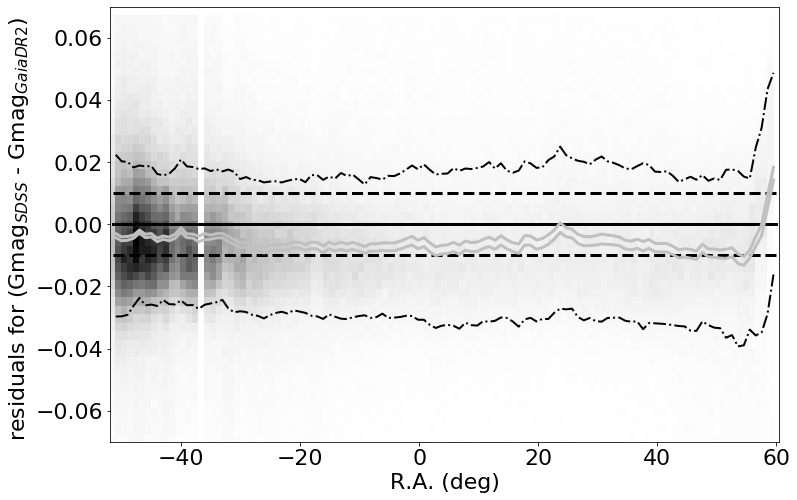

made plot GmagCorrection_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -0.00550926013183657 std.dev.All: 0.0230543828974018
N= 841193 min= -0.09999488482666107 max= 0.09414577941894324
median: -0.005903811336516903 std.dev: 0.006486710758203868
saved plot as: GmagCorrection_Dec.png


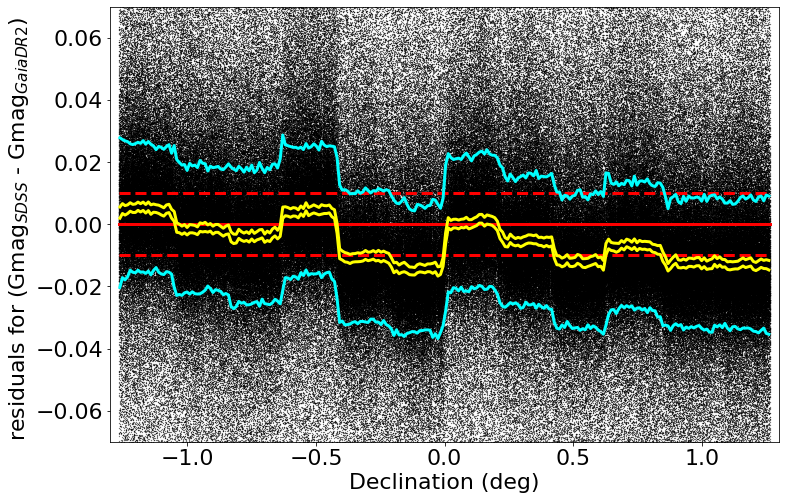

medianAll: -0.00550926013183657 std.dev.All: 0.0230543828974018
N= 841193 min= -0.09999488482666107 max= 0.09414577941894324
median: -0.005903811336516903 std.dev: 0.006486710758203868
saved plot as: GmagCorrection_Dec_Hess.png


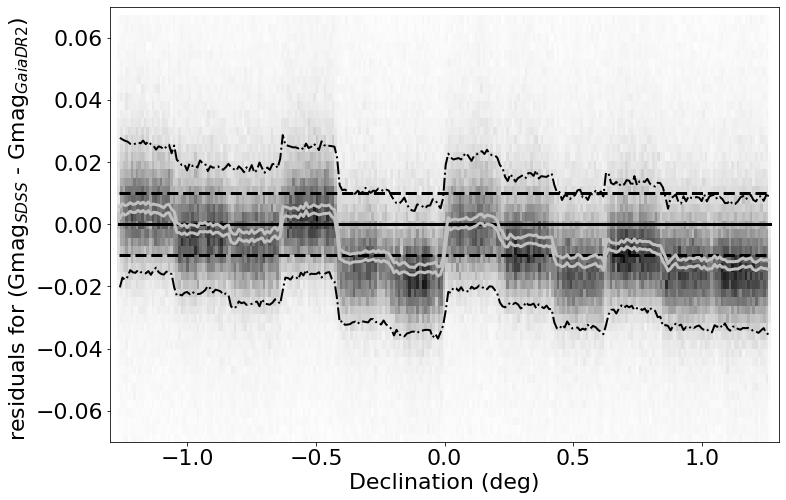

made plot GmagCorrection_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -0.00550926013183657 std.dev.All: 0.0230543828974018
N= 841193 min= -0.09999488482666107 max= 0.09414577941894324
median: -0.007499836299895035 std.dev: 0.005223160148536051
saved plot as: GmagCorrection_Gmag.png


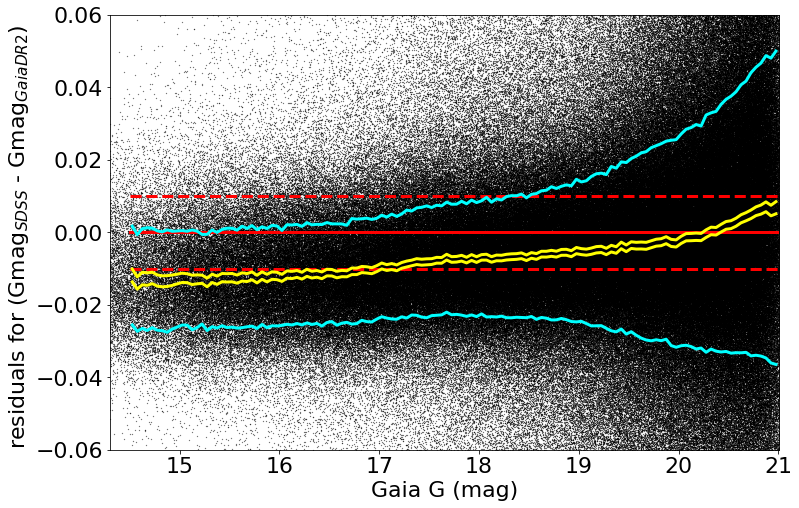

medianAll: -0.00550926013183657 std.dev.All: 0.0230543828974018
N= 841193 min= -0.09999488482666107 max= 0.09414577941894324
median: -0.007499836299895035 std.dev: 0.005223160148536051
saved plot as: GmagCorrection_Gmag_Hess.png


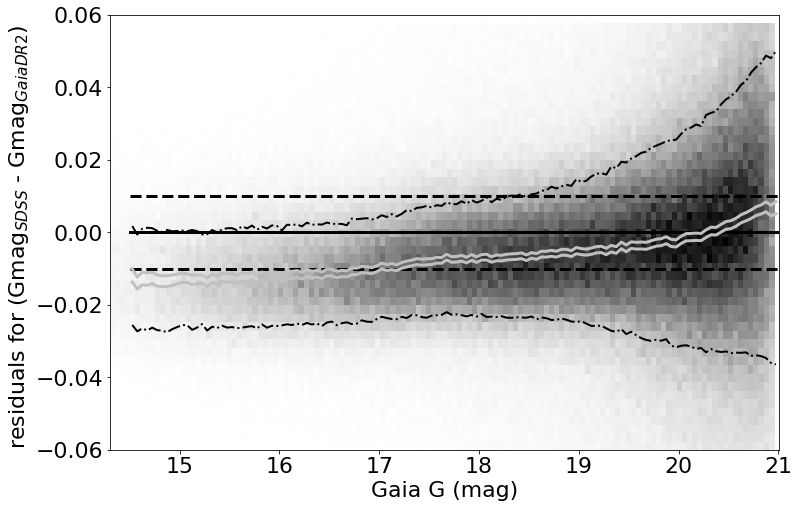

made plot GmagCorrection_Gmag_Hess.png
------------------------------------------------------------------


In [49]:
keywords = {"Ystr":'GrResid', "plotNameRoot":'GmagCorrection', "symbSize":0.05}
plotGmagCorrections(mOKok, keywords) 

In [50]:
!cp GmagCorrection_Gmag_Hess.png GmagCorrectionTest_Gmag_Hess.png

In [51]:
mOKokX = mOKok[(mOKok['Gmag']>15)&(mOKok['Gmag']<15.5)]
print(np.median(mOKokX['GrResid']))

0.012871943557739707


In [52]:
mOKokX = mOKok[(mOKok['Gmag']>16)&(mOKok['Gmag']<16.2)]
print(np.median(mOKokX['GrResid']))

0.011827320716859269


 stats for RA binning medians:
medianAll: -1.2027130125132415e-05 std.dev.All: 0.016836863537382903
N= 373997 min= -0.09812633740234414 max= 0.09999710699462891
median: -0.00039357936859137706 std.dev: 0.0034291182490202294
saved plot as: GmagCorrection_RA.png


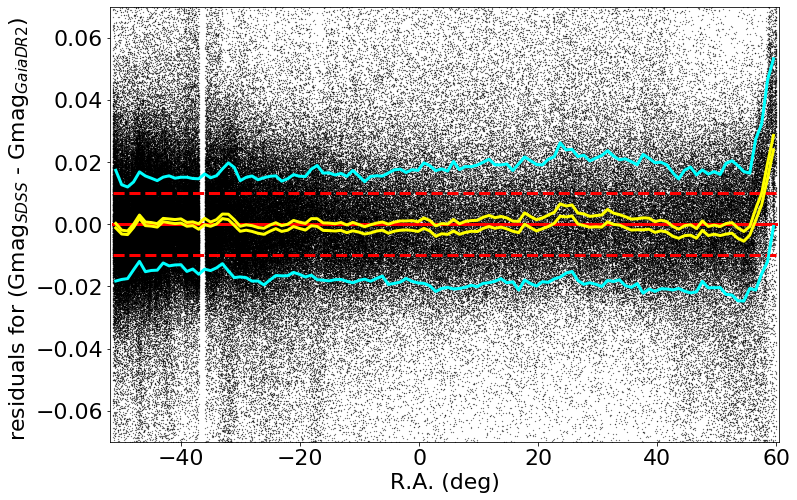

medianAll: -1.2027130125132415e-05 std.dev.All: 0.016836863537382903
N= 373997 min= -0.09812633740234414 max= 0.09999710699462891
median: -0.00039357936859137706 std.dev: 0.0034291182490202294
saved plot as: GmagCorrection_RA_Hess.png


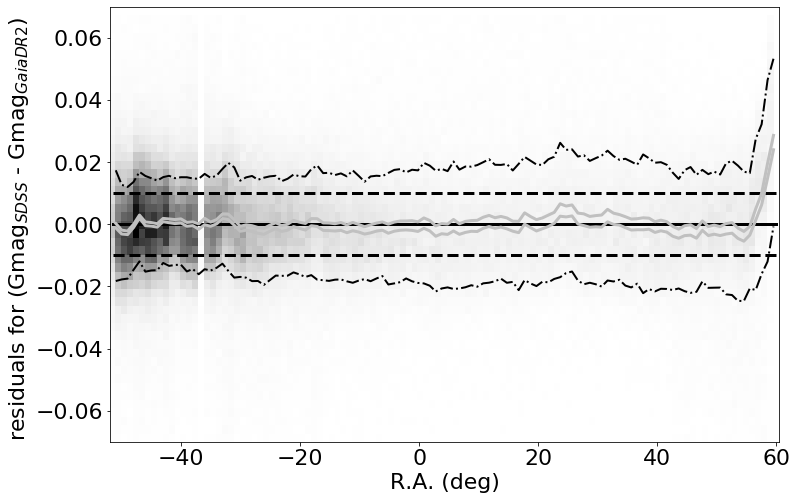

made plot GmagCorrection_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -1.2027130125132415e-05 std.dev.All: 0.016836863537382903
N= 373997 min= -0.09812633740234414 max= 0.09999710699462891
median: -0.000547675609590099 std.dev: 0.006465581647833515
saved plot as: GmagCorrection_Dec.png


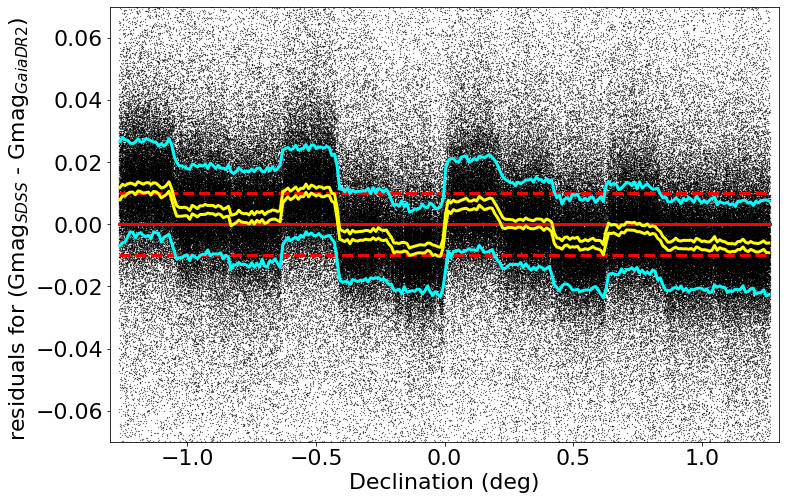

medianAll: -1.2027130125132415e-05 std.dev.All: 0.016836863537382903
N= 373997 min= -0.09812633740234414 max= 0.09999710699462891
median: -0.000547675609590099 std.dev: 0.006465581647833515
saved plot as: GmagCorrection_Dec_Hess.png


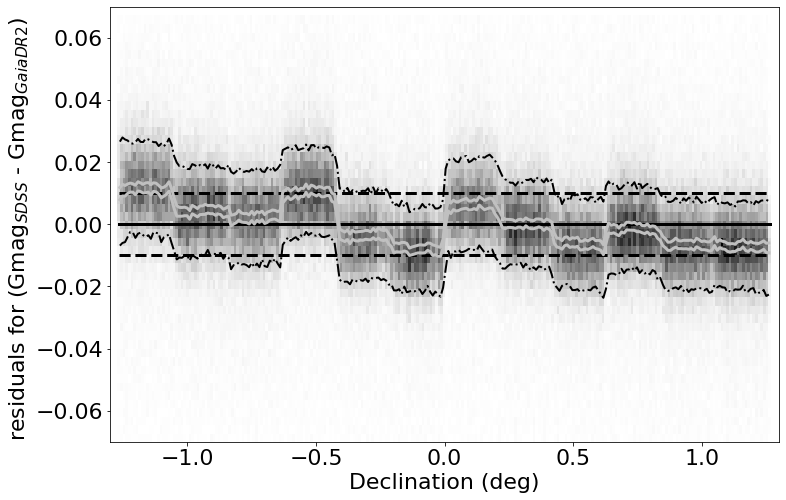

made plot GmagCorrection_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -1.2027130125132415e-05 std.dev.All: 0.016836863537382903
N= 373997 min= -0.09812633740234414 max= 0.09999710699462891
median: 9.854311752122927e-05 std.dev: 0.002358297444607863
saved plot as: GmagCorrection_Gmag.png


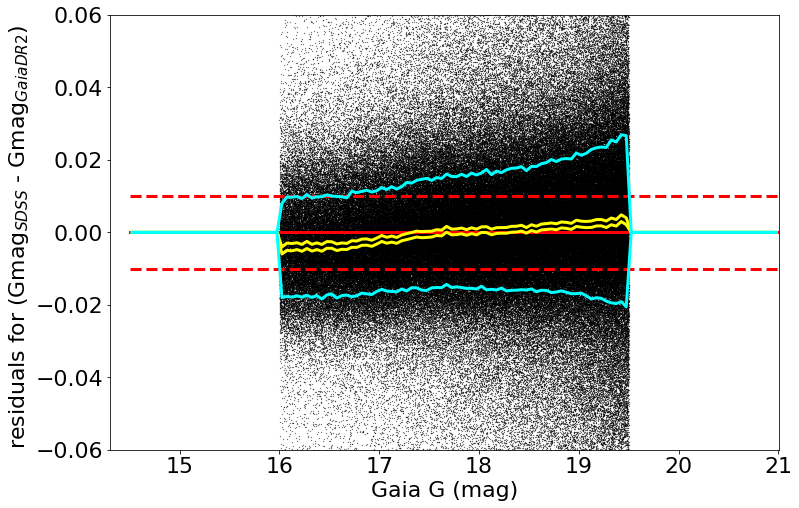

medianAll: -1.2027130125132415e-05 std.dev.All: 0.016836863537382903
N= 373997 min= -0.09812633740234414 max= 0.09999710699462891
median: 9.854311752122927e-05 std.dev: 0.002358297444607863
saved plot as: GmagCorrection_Gmag_Hess.png


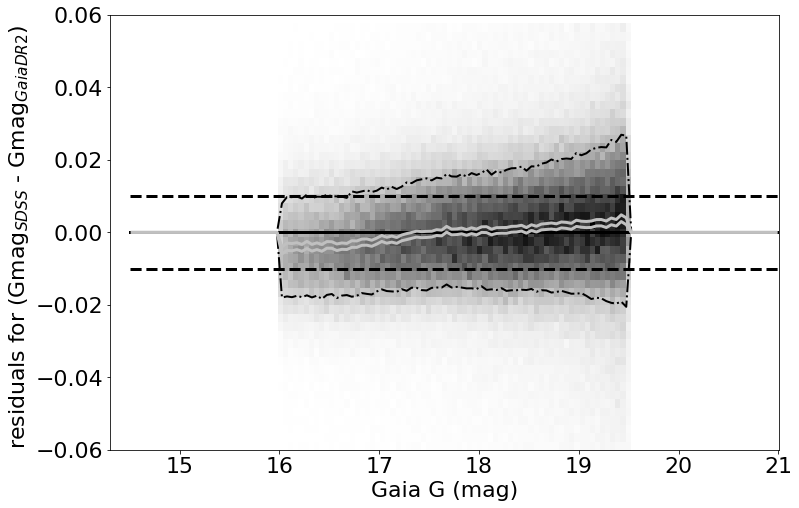

made plot GmagCorrection_Gmag_Hess.png
------------------------------------------------------------------


In [53]:
keywords = {"Ystr":'GrResid', "plotNameRoot":'GmagCorrection', "symbSize":0.05}
plotGmagCorrections(mOKcBok, keywords) 

medianAll: 0.009160339355467784 std.dev.All: 0.0856532116790769
N= 397883 min= -5.81342258911133 max= 10018.501293225097
median: -0.08352484283447215 std.dev: 0.4782360272176294
saved plot as: GrVSgi.png


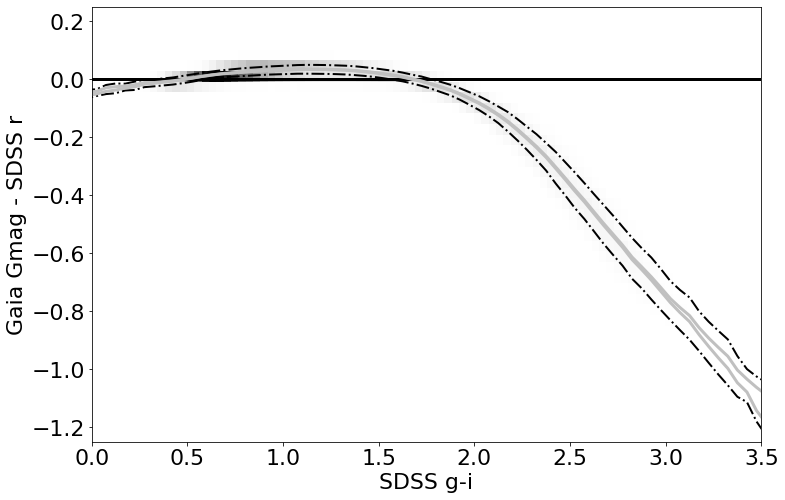

made plot GrVSgi.png


In [54]:
# for calibration: giMin = 0.4 & giMax = 3.0 
mOKB = mOK[(mOK['Gmag']>16)&(mOK['Gmag']<19.5)]
plotGmag2Ddiagrams(mOKB)

In [55]:
mOKB

<Table length=397883>
     ra        dec       nObs  ...          dgGr                 GrResid       
  float64    float64   float64 ...        float64                float64       
----------- ---------- ------- ... ---------------------- ---------------------
 43.5796432  -0.304217   199.0 ...    0.00928171234130909  0.015127215148926348
 27.8832703  1.2180952   188.0 ...  -0.029069080841062522 -0.023223578033445262
 22.5497208   0.122606   521.0 ...   -0.07535690332031231  -0.06951140051269504
 47.6843719   0.770136   201.0 ...    0.01354627882385248  0.019391781631469738
 20.2102833  -0.876041   232.0 ...   0.006340426071166562   0.01218592887878382
 32.3100166  -1.246673   243.0 ...   0.008478305786135315  0.014323808593752574
 18.8583946   0.516484   264.0 ...   0.024166661468505362   0.03001216427612262
  6.0673361   -0.69012   455.0 ...   0.010797309310913182  0.016642812118530442
  55.064106  -0.597732   305.0 ...   0.001381446426392166 0.0072269492340094246
  29.433403  0.7860429   235.0 ...   0.006955409515380598  0.012800912322997855
        ...        ...     ... ...                    ...                   ...
349.3256836   0.000642   268.0 ...   0.018308007614134723  0.024153510421751984
343.0394897   0.774346   165.0 ...  -0.025289839920042443 -0.019444337112425186
315.1004028 -1.1524429   363.0 ...   -0.03713540423584184  -0.03128990142822458
325.3983459  -0.363786   494.0 ...   -0.02971842330932639  -0.02387292050170913
340.2333984   0.338748   174.0 ... -0.0002947762756309591  0.005550726531986299
316.1567078  1.2039244   304.0 ...  -0.023925347305298536 -0.018079844497681276
312.1022644   -0.45234   436.0 ...     -0.063711545104981 -0.057866042297363744
308.9144897  -0.817087   399.0 ...    0.03020830862426993   0.03605381143188719
308.8782043  0.7892348   403.0 ...  0.0065085143737786885  0.012354017181395947
340.9538269   0.302752   153.0 ...   -0.08972739248657036  -0.08388188967895309

### Final Gmag-based recalibration
#### Recalibrate R.A. residuals


In [56]:
RAbin, RAnPts, RAmedianBin, RAsigGbin = zit.fitMedians(mOKcBok['raW'], mOKcBok['GrResid'], -51.5, 60.0, 112, 1)

median: 0.00035661710357612233 std.dev: 0.0034314293508158284


#### Recalibrate Dec residuals

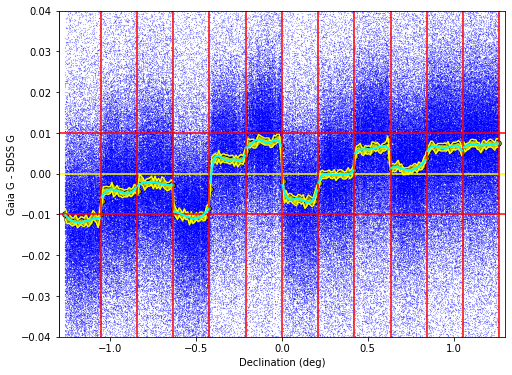

In [57]:
decOK = mOKcBok['dec_new']
GrResid =  mOKcBok['GrResid']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decOK, GrResid, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_ylim(-0.04,0.04)

ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Gaia G - SDSS G')
xBin, nPts, medianBin, sigGbin = zit.fitMedians(decOK, GrResid, -1.266, 1.264, 252, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
dCleft = -1.3
ax.plot(0*xL+dCleft, xL, c='red')
alltheta = []
for i in range(0,12):
    decCol = -1.2655 + (i+1)*0.2109
    ax.plot(0*xL+decCol, xL, c='red')
    xR = xBin[(xBin>dCleft)&(xBin<decCol)]
    yR = medianBin[(xBin>dCleft)&(xBin<decCol)]
    dyR = sigGbin[(xBin>dCleft)&(xBin<decCol)]
    data = np.array([xR, yR, dyR])
    theta2 = zit.best_theta(data,5)
    alltheta.append(theta2)
    yfit = zit.polynomial_fit(theta2, xR)
    ax.plot(xR, yfit, c='cyan', lw=2)
    dCleft = decCol
    rrr = yR - yfit
    # print(i, np.median(rrr), np.std(rrr))  # 2 milimag scatter 
    # print(i, theta2)
plt.savefig('GmagDecCorrections.png')

In [58]:
# let's now correct all mags with this correction
thetaRecalib = alltheta

In [59]:
decLeft = -1.3
for i in range(0,12):
    decRight = -1.2655 + (i+1)*0.2109
    decArr = np.linspace(decLeft, decRight, 100)
    thetaBin = thetaRecalib[i] 
    ZPfit = zit.polynomial_fit(thetaBin, decArr)
    if (i==0):
        decCorrGrid = decArr
        ZPcorr = ZPfit
    else: 
        decCorrGrid = np.concatenate([decCorrGrid, decArr]) 
        ZPcorr = np.concatenate([ZPcorr, ZPfit])
    decLeft = decRight

In [60]:
mOKtest = mOK[mOK['r_Nobs_new']>3]

In [61]:
# Dec correction
decGrid2correct = mOKtest['dec_new']
ZPcorrectionsDec = np.interp(decGrid2correct, decCorrGrid, ZPcorr)
# RA correction 
raWGrid2correct = mOKtest['raW'] 
ZPcorrectionsRA = np.interp(raWGrid2correct, RAbin, RAmedianBin)
print(np.std(ZPcorrectionsDec), np.std(ZPcorrectionsRA))

0.006463916651081474 0.0029086899141108143


Text(0, 0.5, 'Correction')

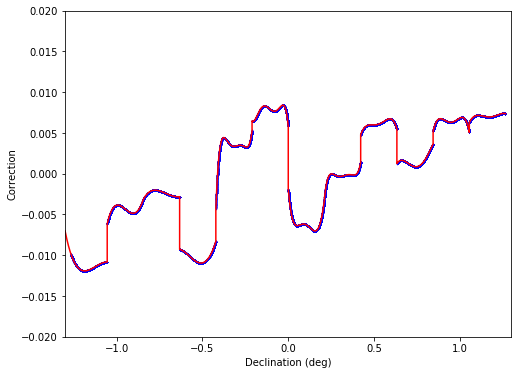

In [62]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decGrid2correct, ZPcorrectionsDec, s=0.01, c='blue')
ax.plot(decCorrGrid, ZPcorr, c='red')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.02,0.02)
ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Correction')

-0.026330507171629762

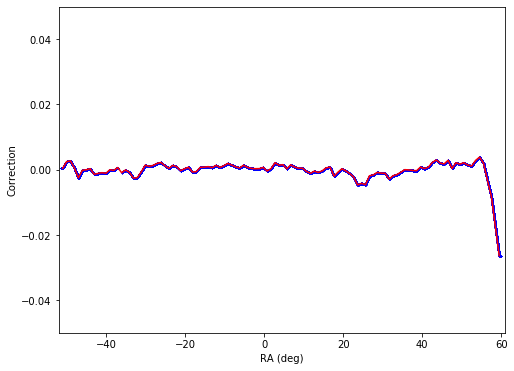

In [63]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raWGrid2correct, ZPcorrectionsRA, s=0.01, c='blue')
ax.plot(RAbin, RAmedianBin, c='red')
ax.set_xlim(-52,61)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Correction') 
np.min(ZPcorrectionsRA)

## Now save correction arrays, then apply to original file, and then test

In [65]:
np.savetxt('ZPcorrectionsRA_v4.1_final.dat', (RAbin, RAmedianBin)) 
np.savetxt('ZPcorrectionsDec_v4.1_final.dat', (decCorrGrid, ZPcorr))

In [66]:
sdssOut = sdss[sdss['ra_new']<1]
sdssOut = zit.selectCatalog(sdss, sdssOut)

starting with 1000140
after Nobs cuts: 996147
after chi2 cuts: 993774
after r_mErr cut: 991472


In [67]:
sdssOut.sort('calib_fla_new') 

In [68]:
# read back gray zero point recalibration files 
zpRAgrid, zpRA = np.loadtxt('ZPcorrectionsRA_v4.1_final.dat')  
zpDecgrid, zpDec = np.loadtxt('ZPcorrectionsDec_v4.1_final.dat')  

In [69]:
sdssOut

<Table length=991472>
calib_fla_new   ra_new    dec_new  ... z_chi2_old    sep_2d_arcsec    
    int64      float64    float64  ...  float64         float64       
------------- ---------- --------- ... ---------- --------------------
            0 308.500219 -1.227713 ...        2.4  0.03474449757496403
            1 308.500072 -1.240266 ...        0.5  0.07084046480551703
            2 308.500101 -1.217158 ...        0.1  0.03466673452960244
            3 308.501912 -1.176494 ...        0.2   0.0719174273633277
            4 308.504615 -1.174191 ...        3.0  0.02551193350101859
            5 308.501254 -1.119302 ...        0.0  0.20998936152791098
            6 308.503096 -1.132302 ...        0.3  0.04931036933104122
            7 308.507505 -1.225594 ...        0.6   0.2113023250422444
            8 308.508754 -1.213904 ...        0.8   0.1263362575655659
            9 308.509244 -1.119027 ...        0.8  0.09977959388492581
          ...        ...       ... ...        ...                  ...
      1006820    59.4026  0.640282 ...        2.2 0.004394269792702601
      1006821  59.206487   -0.1286 ...        1.8 0.038275208778733805
      1006822  59.789954 -0.545131 ...        0.2  0.10464399689965577
      1006823  59.421151  1.192797 ...        1.3 0.011177244998718859
      1006824  59.944536  0.258336 ...        1.3 0.022426957628154283
      1006825  59.950044  0.973698 ...        0.3 0.019718829978823727
      1006826  59.068719 -0.701496 ...        0.8 0.011384114259599133
      1006827  59.940965  0.068224 ...        1.2  0.02923766146639862
      1006828  59.111628   0.75308 ...        0.7  0.10942639855703964
      1006829  59.040318 -0.052222 ...        0.6 0.007421589943654063

In [70]:
# Dec correction
decGrid2correct = sdssOut['dec_new']
ZPcorrectionsDec = np.interp(decGrid2correct, zpDecgrid, zpDec)

# RA correction 
ra = sdssOut['ra_new'] 
raWGrid2correct = np.where(ra > 180, ra-360, ra) 
ZPcorrectionsRA = np.interp(raWGrid2correct, zpRAgrid, zpRA)
print('gray std RA/Dec:', np.std(ZPcorrectionsRA), np.std(ZPcorrectionsDec)) 

for b in ('u', 'g', 'r', 'i', 'z'):
    for mtype in ('_mMed_new', '_mMean_new'):
        mstr = b + mtype
        # applying here gray corrections  
        sdssOut[mstr] = sdssOut[mstr] + ZPcorrectionsRA + ZPcorrectionsDec 

gray std RA/Dec: 0.0028799985573326565 0.006456031643818393


In [71]:
SSCindexRoot = 'CALIBSTARS_'
outFile = ZIdataDir + "/" + "stripe82calibStars_v4.1_noheader_final.dat"
newSSC = open(outFile,'w')
df = sdssOut
Ngood = 0
for i in range(0, np.size(df)):
    Ngood += 1
    NoldCat = df['calib_fla_new'][i]
    strNo = f'{Ngood:07}'
    SSCindex = SSCindexRoot + strNo 
    SSCrow = zit.getSSCentry(df, i)
    zit.SSCentryToOutFileRow(SSCrow, SSCindex, newSSC) 
newSSC.close()
print(Ngood, 'rows in file', outFile)

991472 rows in file /Users/ivezic/Work/Science/CalibrationV2/SDSS_SSC/Data/stripe82calibStars_v4.1_noheader_final.dat
